In [1]:
library(Seurat)
library(tidyverse)
library(patchwork)
library(Signac)
library(ggplot2)
library(data.table)
library(dplyr)
library(scCustomize)
library(tidydr)
library(GenomicRanges)
library(pheatmap)
library(Matrix)
library(TFBSTools)
library(chromVAR)
library(JASPAR2020)
library(BuenColors)
library(doParallel)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
# library(harmony)
# library(cicero)
#library(networkD3)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, y

In [2]:
my36colors <- c('#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87', '#E95C59', '#E59CC4', '#E5D2DD', '#AB3282', '#BD956A', 
                '#8C549C', '#E0D4CA', '#C5DEBA', '#58A4C3', '#E4C755', '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', 
                '#B53E2B', '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963','#968175')

# mouse brain relative analysis

In [3]:
rna <- readRDS('./Brain/Integration_RNA_postQC_annotation.rds')

In [4]:
atac <- readRDS('./Brain/Integration_ATAC_postQC_annotation.rds')

In [5]:
DefaultAssay(atac)='ATAC'
##remodel object annotation/gtf(annotation$tx_id=annotation$transcript_id)
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
genome(annotations) <- "mm10"
seqlevelsStyle(annotations) <- 'UCSC'
levels(annotations@seqnames) <- c("chrX","chr1","chr6","chr3","chr7","chr12","chr11","chr4","chr17","chr2","chr16","chr8","chr19","chr9",
                                  "chr13","chr14","chr5","chr10","chrY","chr18","chr15","chrM")
annotations@seqinfo@seqnames <- c("chrX","chr1","chr6","chr3","chr7","chr12","chr11","chr4","chr17","chr2","chr16","chr8","chr19","chr9",
                                  "chr13","chr14","chr5","chr10","chrY","chr18","chr15","chrM")
atac@assays$ATAC@annotation=annotations

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: ‘AnnotationFilter’


The following object is masked from ‘package:magrittr’:

    not


The following object is masked from ‘package:future’:

    value



Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:stats':

    filter


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects h

In [6]:
# gene activity
gene.activities <- GeneActivity(atac)
atac[['RNA']] <- CreateAssayObject(counts = gene.activities)
# normalize gene activities
DefaultAssay(atac) <- "RNA"
atac <- NormalizeData(object = atac, assay = 'RNA',normalization.method = 'LogNormalize',scale.factor = median(atac$nCount_RNA))

In [7]:
# chromVAR
DefaultAssay(atac) <- "ATAC"
pfm <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE))
atac <- AddMotifs(object = atac, genome = BSgenome.Mmusculus.UCSC.mm10, pfm = pfm)
atac <- RunChromVAR(object = atac, genome = BSgenome.Mmusculus.UCSC.mm10)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



## ATAC、RNA integration

In [8]:
rna

An object of class Seurat 
27080 features across 23307 samples within 1 assay 
Active assay: RNA (27080 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [9]:
atac

An object of class Seurat 
206837 features across 23307 samples within 3 assays 
Active assay: RNA (21821 features, 0 variable features)
 2 layers present: counts, data
 2 other assays present: ATAC, chromvar
 2 dimensional reductions calculated: integrated_lsi, umap.atac

In [10]:
brain=rna
# 
brain[['ATAC']]=atac[['ATAC']]
brain[['integrated_lsi']]=atac[['integrated_lsi']]
brain[['umap.atac']]=atac[['umap.atac']]
brain$nCount_ATAC=atac$nCount_ATAC
brain$nFeature_ATAC=atac$nFeature_ATAC
brain$ATAC_snn_res.0.1=atac$ATAC_snn_res.0.1
brain$ATAC_snn_res.0.3=atac$ATAC_snn_res.0.3
brain$ATAC_snn_res.0.5=atac$ATAC_snn_res.0.5
brain$ATAC_snn_res.0.8=atac$ATAC_snn_res.0.8
brain[['atac_celltype']]=atac[['CellType']]
colnames(brain@meta.data)[colnames(brain@meta.data) == "CellType"] <- 'rna_celltype'

In [11]:
brain <- FindMultiModalNeighbors(brain, reduction.list = list("harmony", "integrated_lsi"), dims.list = list(1:30, 2:30))
brain <- RunUMAP(brain, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
brain <- FindClusters(brain, graph.name = "wsnn", algorithm = 3, resolution = c(0.1, 0.3, 0.5), verbose = FALSE)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:33:55 UMAP embedding parameters a = 0.9922 b = 1.112

22:33:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

22:34:05 Initializing from normalized Laplacian + noise (using RSpectra)

22:34:12 Commencing optimization for 200 epochs, with 716254 positive edges

22:34:59 Optimization finished



In [12]:
brain

An object of class Seurat 
211350 features across 23307 samples within 2 assays 
Active assay: RNA (27080 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap

In [13]:
saveRDS(brain,'./Brain/brain_rna_atac.rds')

# visualizasion

In [14]:
brain <- readRDS('./Brain/brain_rna_atac.rds') # Misc removed

In [15]:
Idents(brain) <- "rna_celltype"
brain <-  subset(brain, idents='Misc',invert=TRUE) # remove Misc
celltype <- c('In_HAP1_SCN5A','Ex_L5_ET','Ex_NDG_NECTIN3','Ex_L6_CT','In_MGE_SST','Ex_NDG_NDST4','Ex_L6_IT','In_MGE_PVALB','Ex_L5 IT','Astrocyte','Oligodendrocyte','Ex_L2_3','In_CGE_RELN','OPC',
         'Ex_L5_6_IT','Ex_L6b','Microglia','Endothelia','In_PLI','Dopaminergic_neuron')
brain$rna_celltype <- factor(brain$rna_celltype, levels = celltype)

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


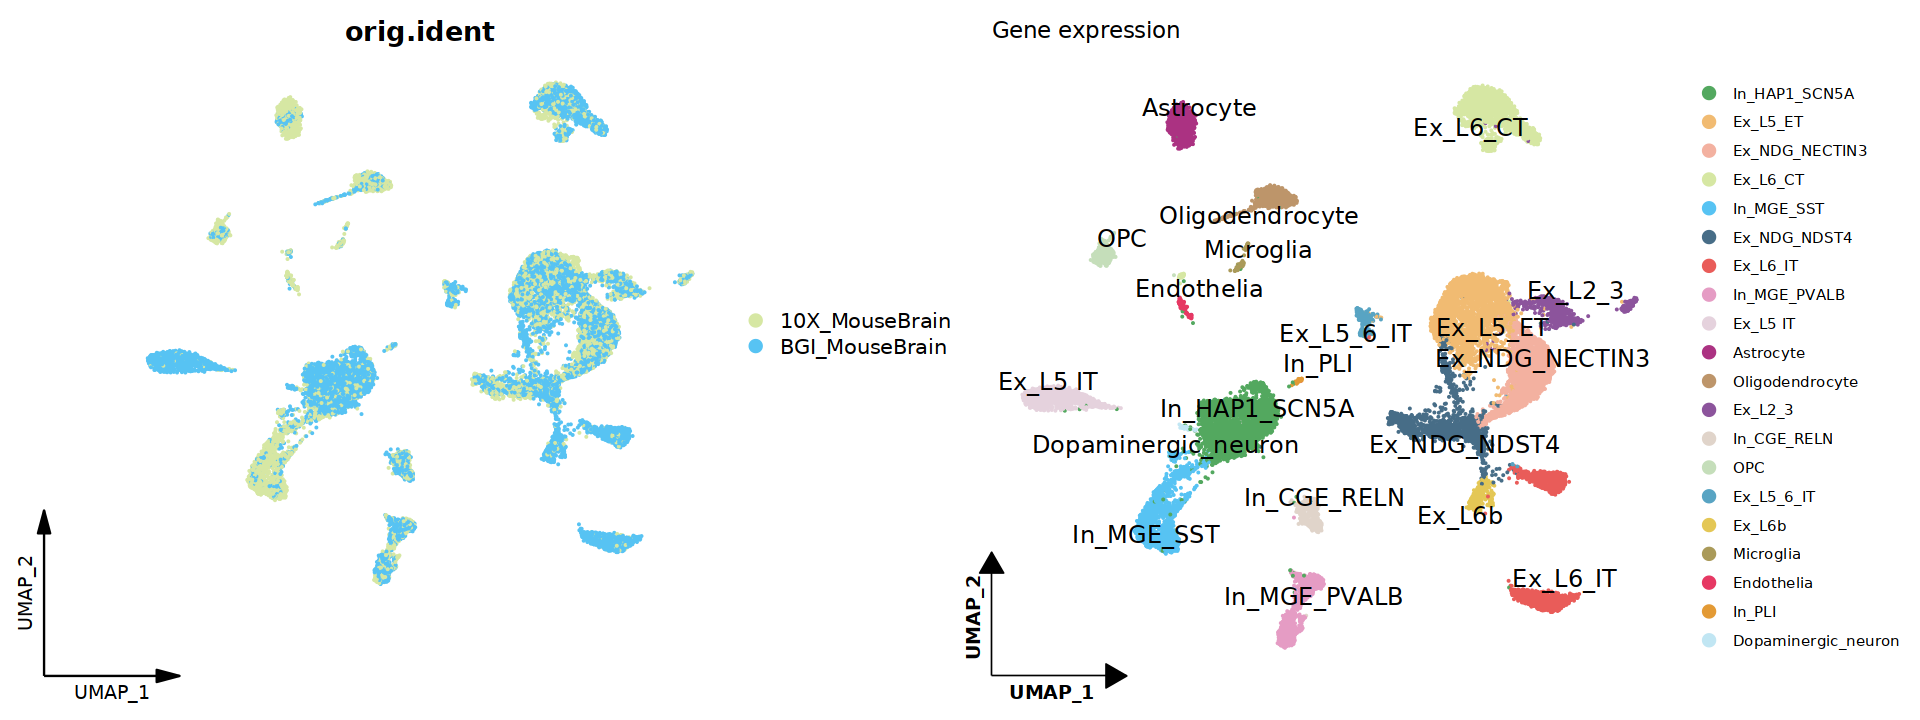

In [16]:
DefaultAssay(brain) <- 'RNA'
options(repr.plot.width=16, repr.plot.height=6)
p1=DimPlot_scCustom(brain, group.by = "orig.ident", label.size = 4,colors_use = c('#D6E7A3', '#57C3F3'),figure_plot = TRUE)
p2=DimPlot(brain, group.by = "rna_celltype", label = TRUE, repel = TRUE, label.size = 5,cols = my36colors) + 
        theme_dr(xlength = 0.2, ylength = 0.2, arrow = arrow(length = unit(0.2, "inches"),type = "closed")) +
        theme(panel.grid = element_blank(), axis.title = element_text(face = 2,hjust = 0.03)) + ggtitle("Gene expression")
p1|p2

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


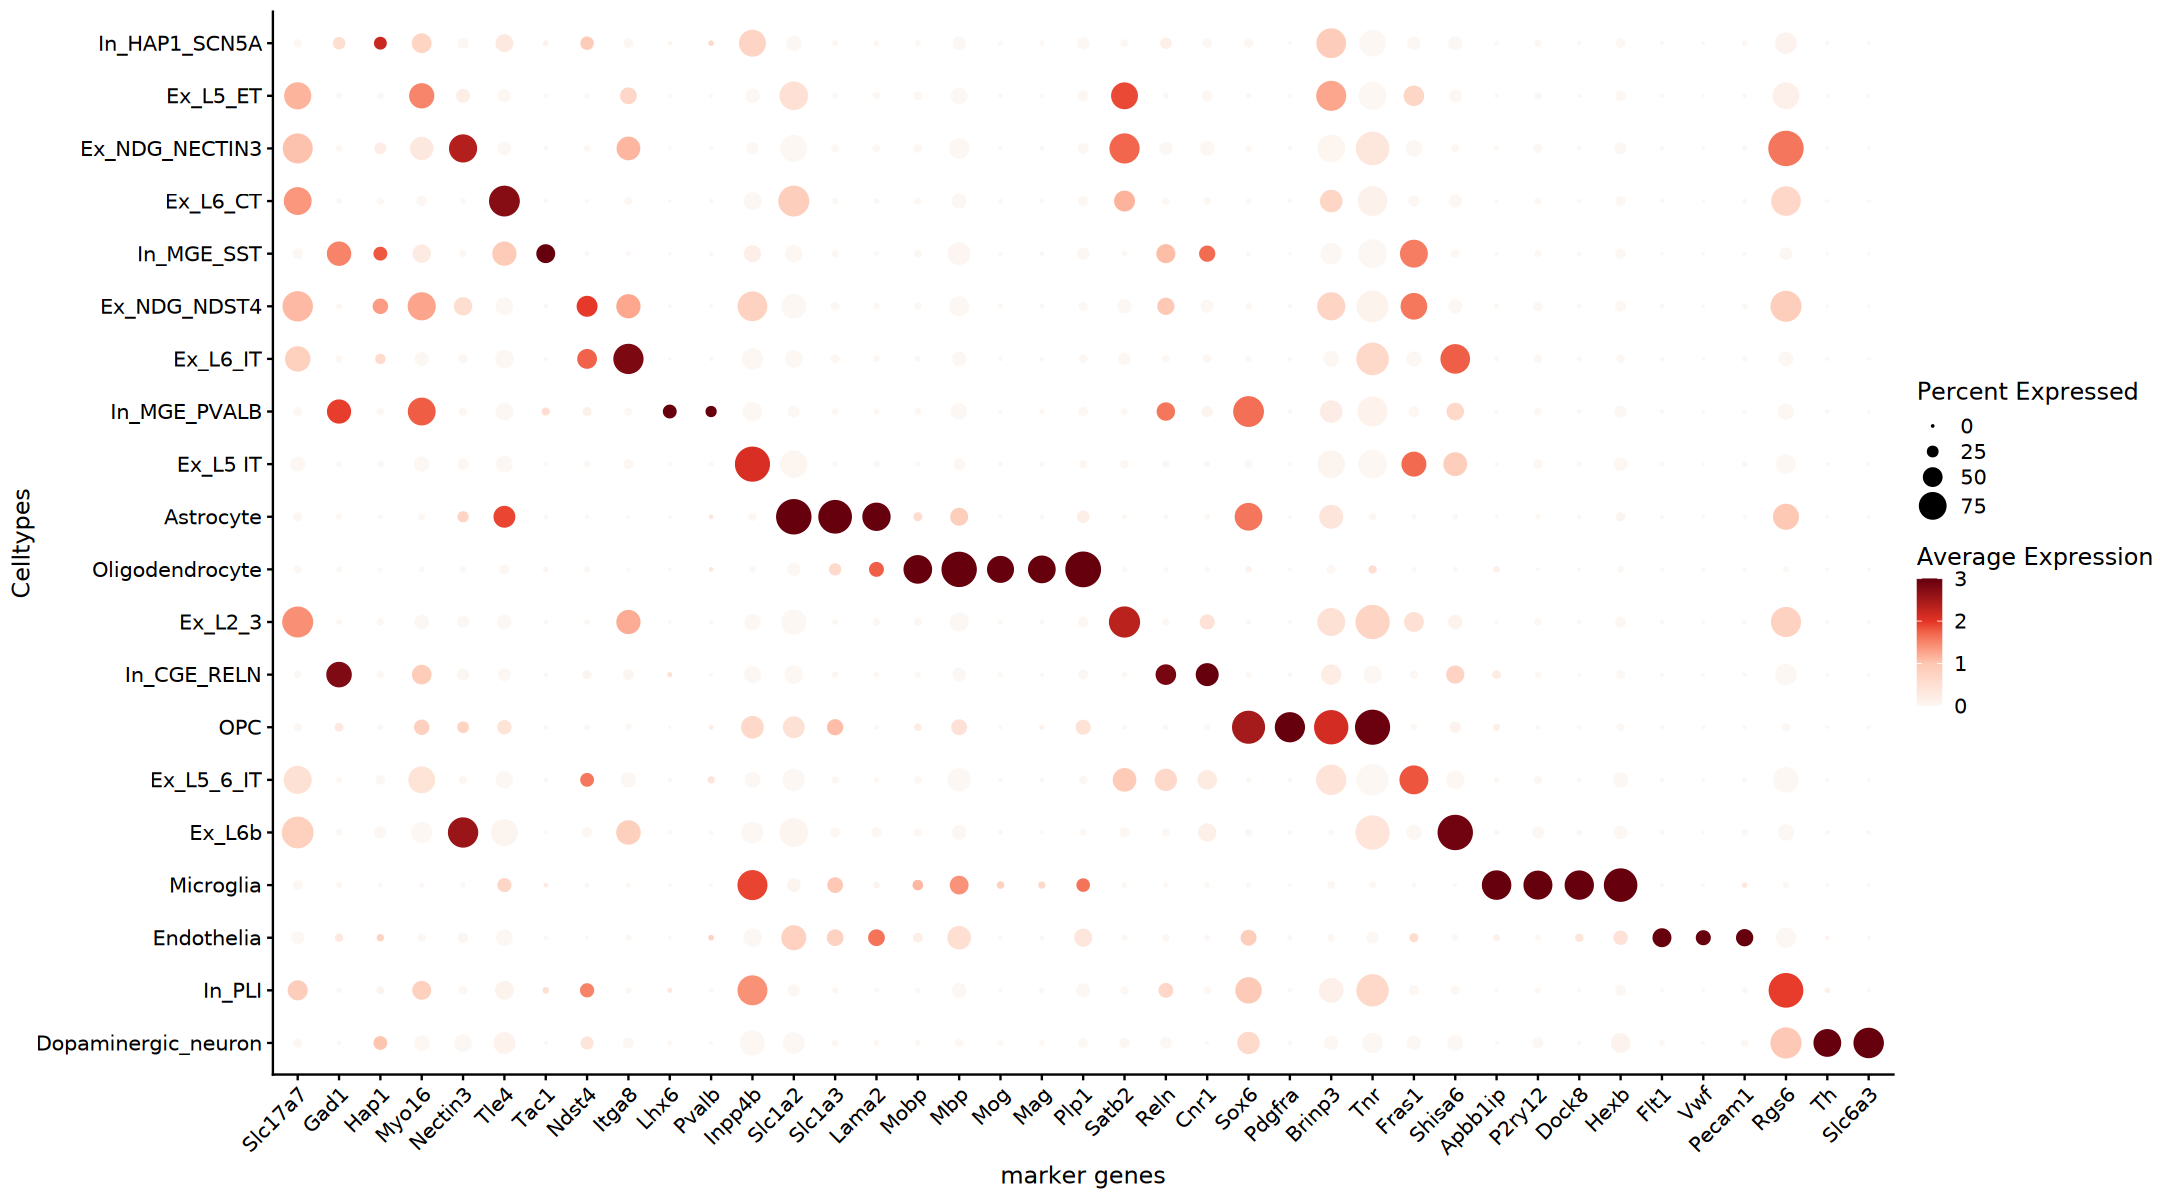

In [3]:
DefaultAssay(brain) <- 'RNA'
options(repr.plot.width=18, repr.plot.height=10)
makerlist1<- c('Slc17a7', 'Gad1','Hap1','Myo16','Nectin3','Tle4','Tac1','Ndst4','Itga8','Lhx6','Pvalb','Inpp4b','Slc1a2','Slc1a3','Lama2',
               'Mobp','Mbp','Mog','Mag','Plp1','Satb2','Reln','Cnr1','Sox6','Pdgfra','Brinp3','Tnr','Fras1',
               'Shisa6','Apbb1ip','P2ry12','Dock8','Hexb','Flt1','Vwf','Pecam1','Rgs6','Th','Slc6a3')
#
#figure3 RNA use maker
Idents(object = brain) <- "rna_celltype"
p5 <- Seurat::DotPlot(brain, features = makerlist1, group.by='rna_celltype', scale = TRUE, cluster.idents=FALSE, col.min = 0,col.max = 3, dot.scale=9) + RotatedAxis() + 
     scale_color_gradientn(colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 200/255, 180/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255))) + #(colours = c(rgb(252/255, 247/255, 243/255),rgb(237/255, 213/255, 192/255),rgb(224/255, 147/255, 121/255),rgb(176/255, 49/255, 51/255),rgb(81/255, 24/255, 29/255)))
     xlab('marker genes') + ylab('Celltypes') + scale_y_discrete(limits=rev(levels(brain))) + scale_x_discrete(limits=makerlist1)
#colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 200/255, 180/255),rgb(249/255, 147/255, 118/255),rgb(249/255, 120/255, 90/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255))
p5

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


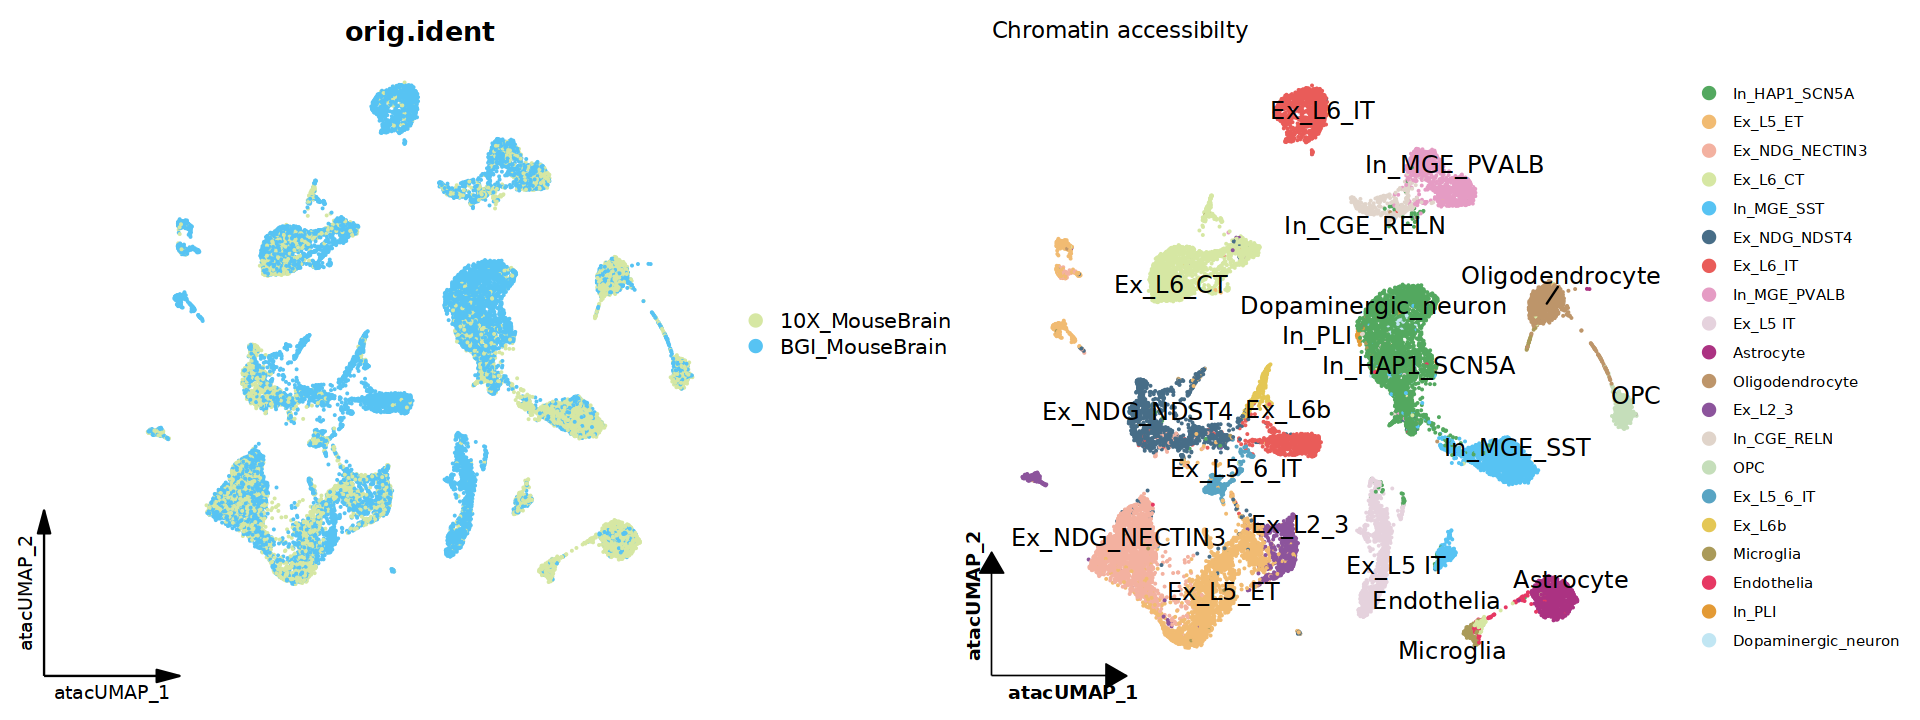

In [17]:
DefaultAssay(brain) <- 'ATAC'
options(repr.plot.width=16, repr.plot.height=6)
p3=DimPlot_scCustom(brain, group.by = "orig.ident", label.size = 4,colors_use = c('#D6E7A3', '#57C3F3'),figure_plot = TRUE)
p4=DimPlot(brain, group.by = "rna_celltype", label = TRUE, repel = TRUE, label.size = 5,cols = my36colors) + 
        theme_dr(xlength = 0.2, ylength = 0.2, arrow = arrow(length = unit(0.2, "inches"),type = "closed")) +
        theme(panel.grid = element_blank(), axis.title = element_text(face = 2,hjust = 0.03)) +  ggtitle("Chromatin accessibilty")
p3|p4

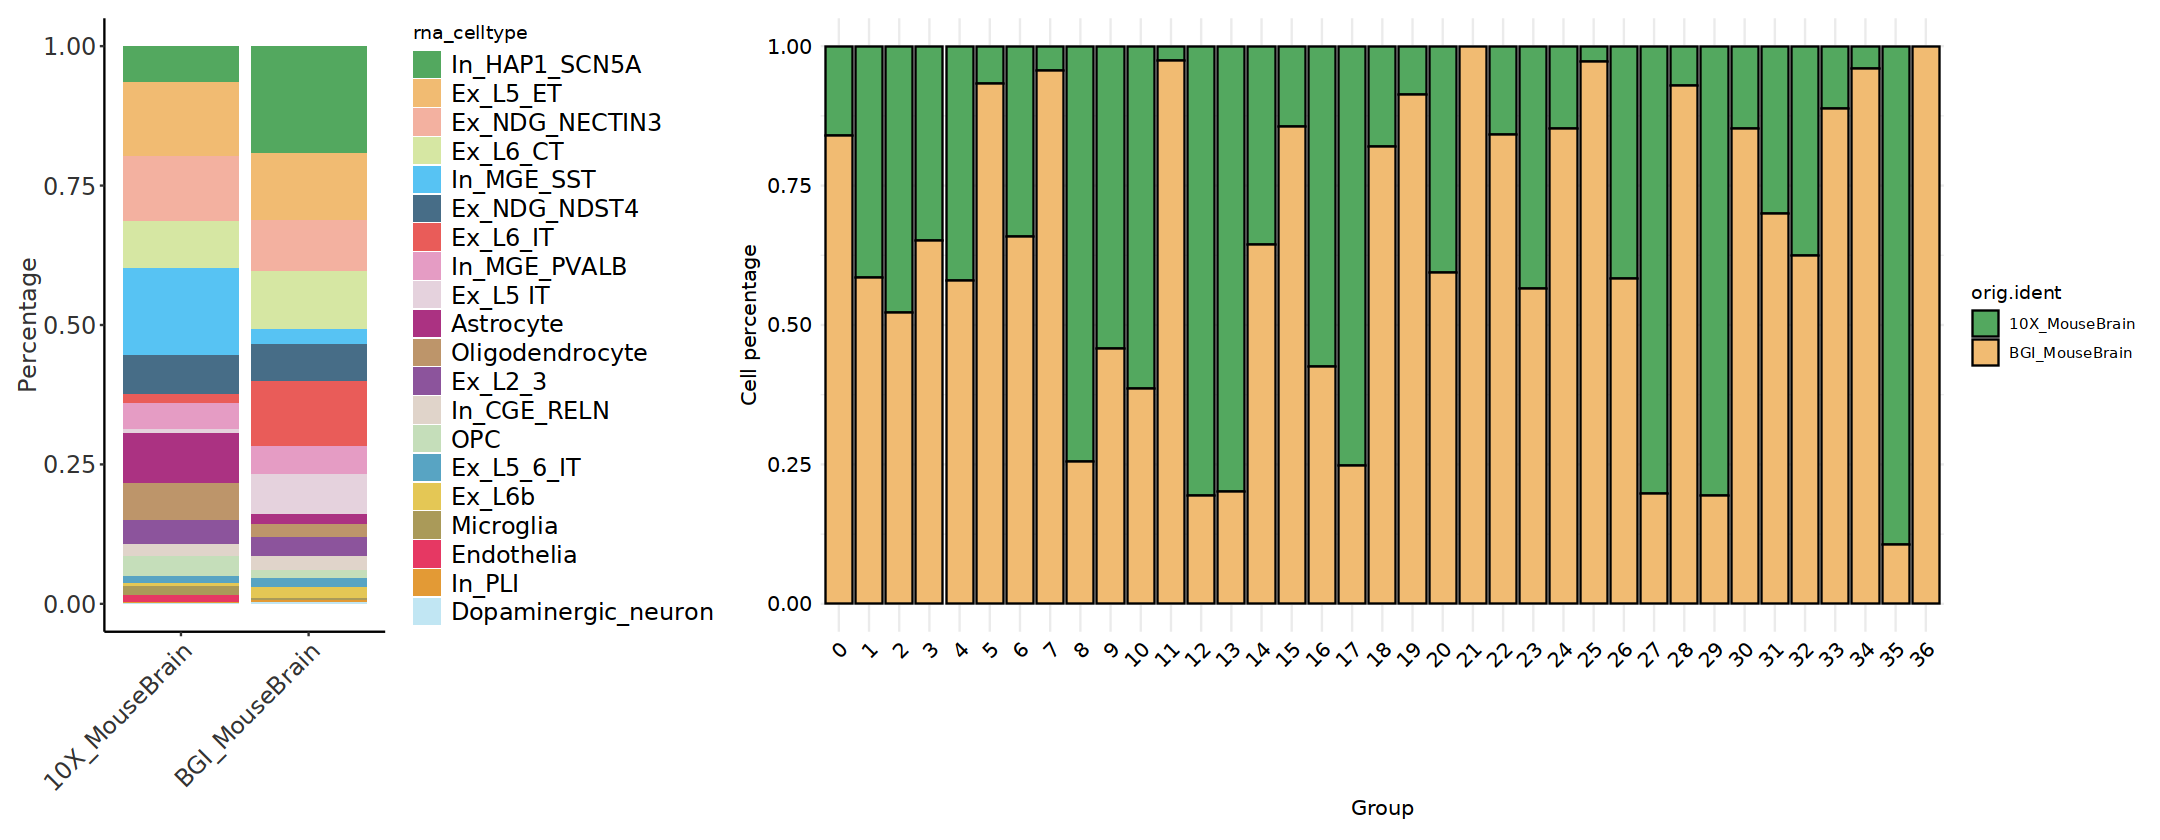

In [18]:
#### cell ratio plot ####
#colors_use <- scCustomize_Palette(num_groups = 30, ggplot_default_colors = FALSE, color_seed = 123)
#
style = theme(axis.text.x = element_text(color = "grey20", size = 14, angle = 90, face = "plain"), axis.text.y = element_text(color = "grey20", size = 14, angle = 0, face = "plain"),  
        axis.title.x = element_text(color = "grey20", size = 14, angle = 0, face = "plain"), axis.title.y = element_text(color = "grey20", size = 14, angle = 90, face = "plain"),
        panel.grid = element_blank(), panel.background = element_rect(fill = "transparent",colour = NA), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black") ,
        plot.title = element_text(lineheight=.8, face="bold", hjust=0.5, size =16), legend.text = element_text(size=14))
#
Cell_percentage_Group <- function(object=object){
  ggplot(object@meta.data,aes(y=seurat_clusters,fill=orig.ident))+
    geom_bar(position = "fill",colour='black')+ labs(x="Cell percentage",y='Group')+scale_fill_manual(values=my36colors)+
    theme_minimal()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+coord_flip() +
    theme(axis.title=element_text(size=12,color="black"), # 
          axis.text = element_text(size=12,color="black"), # 
          axis.text.x = element_text(angle = 45, hjust = 1))
}
#
options(repr.plot.width=18, repr.plot.height=7)
p1 <- ggplot(brain@meta.data,aes(x=orig.ident,fill=rna_celltype)) + 
    geom_bar(position="fill") + scale_fill_manual(values=my36colors) + 
    style + labs(y="Percentage") + RotatedAxis() + xlab('')
p2 <- Cell_percentage_Group(brain)
p1+p2+plot_layout(ncol = 2, widths = c(1, 4))

## 10x vs scCAT celltype correlation

In [19]:
# 
brain[['neuron']] <- brain[['rna_celltype']]
brain[['neuron']] <- brain[['neuron']] %>%
  mutate(neuron = ifelse(neuron %in% c("OPC", "Oligodendrocyte", "Astrocyte", "Microglia", "Endothelia"), "Non-neuron",
                    ifelse(neuron %in% c("In_HAP1_SCN5A","In_MGE_PVALB", "In_CGE_RELN", "In_MGE_SST", "In_PLI"), "Inhibitory neuron",
                      ifelse(neuron %in% c("Ex_L5_ET", "Ex_NDG_NECTIN3", "Ex_L6_CT", "Ex_NDG_NDST4", "Ex_L6_IT", "Ex_L5 IT", "Ex_L2_3", "Ex_L6b", "Dopaminergic_neuron","Ex_L5_6_IT"), "Excitatory neuron",neuron))))

In [20]:
# 
neuron_value <- "Inhibitory neuron" # Non-neuron  Excitatory neuron  Inhibitory neuron
# 10x
batch_values <- c("batch1", "batch2", "batch3", "batch4")
req_names <- paste0("multi_req", seq_along(batch_values))
for (i in seq_along(batch_values)) {   
  batch <- brain[, brain$batch == batch_values[i] & brain$neuron == neuron_value]
  assign(req_names[i], GetAssayData(batch, assay = "RNA"))
}
# scCAT
batch_names <- c("Cortex_EL13", "Cortex_EL14", "Cortex_EL15", "Cortex_EL16")
EL_names <- paste0("EL", seq(13, 16))
for (i in seq_along(batch_names)) {
  sub_seurat_object <-  brain[,  brain$batch == batch_names[i] &  brain$neuron == neuron_value]
  EL <- GetAssayData(sub_seurat_object, assay = "RNA")
  assign(EL_names[i], EL)
}

In [21]:
multi_req1 <- data.frame((apply(as.matrix(multi_req1), 1, sum)))
multi_req2 <- data.frame((apply(as.matrix(multi_req2), 1, sum)))
multi_req3 <- data.frame((apply(as.matrix(multi_req3), 1, sum)))
multi_req4 <- data.frame((apply(as.matrix(multi_req4), 1, sum)))
#
EL13 <- data.frame((apply(as.matrix(EL13), 1, sum)))
EL14 <- data.frame((apply(as.matrix(EL14), 1, sum)))
EL15 <- data.frame((apply(as.matrix(EL15), 1, sum)))
EL16 <- data.frame((apply(as.matrix(EL16), 1, sum)))
multiome <- cbind(multi_req1, multi_req2, multi_req3, multi_req4)
colnames(multiome) <- c("10X_multi_1", "10X_multi_2", "10X_multi_3","10X_multi_4")
scCAT <- cbind(EL13, EL14, EL15, EL16)
colnames(scCAT) <- c("EL13", "EL14", "EL15", "EL16")

In [22]:
multiome <- log2(multiome + 1)
scCAT <- log2(scCAT + 1)

In [23]:
write.csv(multiome,'./Brain/10x_cortex_Inhibitneuron.csv')
write.csv(scCAT,'./Brain/CAT_cortex_Inhibitneuron.csv')
# # 
# write.csv(multiome,'./Brain/10x_cortex_Excitneuron.csv')
# write.csv(scCAT,'./Brain/CAT_cortex_Excitneuron.csv')
#
# write.csv(multiome,'./Brain/10x_cortex_Nonneuron.csv')
# write.csv(scCAT,'./Brain/CAT_cortex_Nonneuron.csv')
## visualization see 02.1_brain

## 10x vs sc nfeature/ncounts

In [24]:
brain[['UMI']] <- brain[['nCount_RNA']]/1000
brain[['Gene']] <- brain[['nFeature_RNA']]/1000
brain[['fragment']] <- brain[['nCount_ATAC']]/1000

Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”


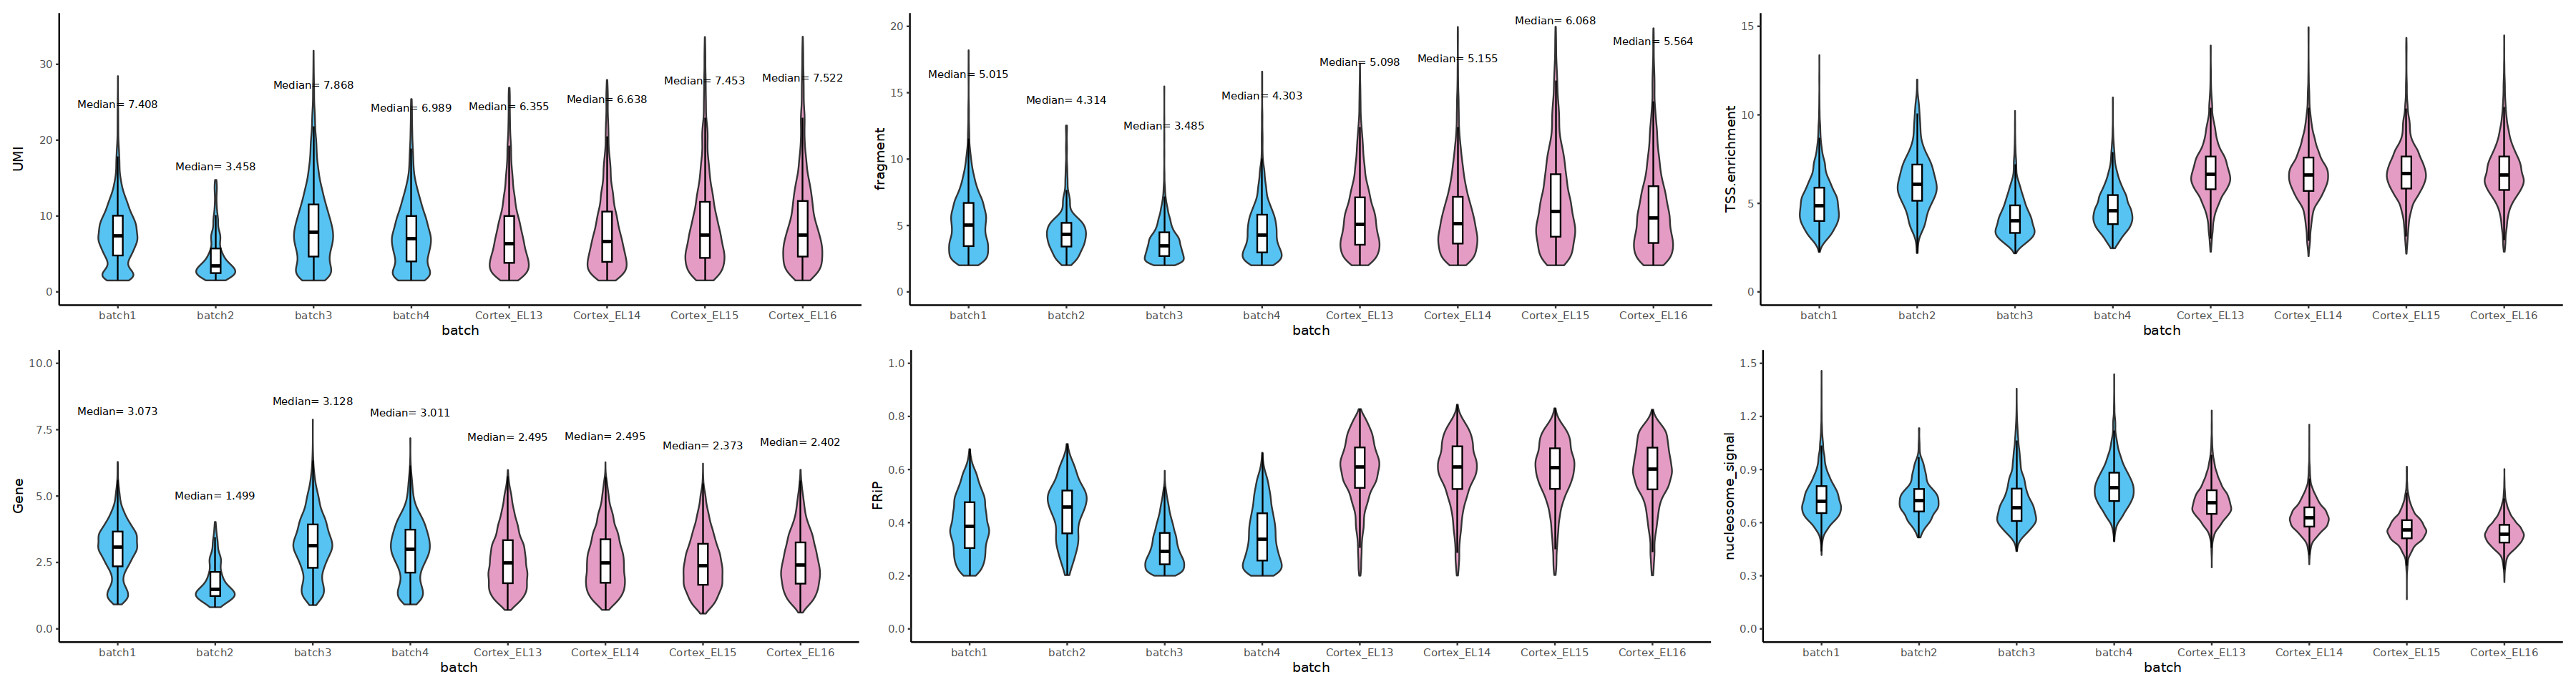

In [25]:
options(repr.plot.width=30, repr.plot.height=8)
p1 <- ggplot(brain@meta.data, aes(x = batch, y = UMI, fill = batch)) +
  geom_violin(position = position_dodge(0.2), width = 0.4, trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  stat_summary(fun.data = function(x) data.frame(y=mean(x)*2.6, label = paste("Median=", round(median(x), 3))), geom="text",size = 3,vjust = -4) +  # median
  scale_y_continuous(limits = c(0, 35), breaks = seq(0, 35, 10)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))
p2 <- ggplot(brain@meta.data, aes(x = batch, y = Gene, fill = batch)) +
  geom_violin(width = 0.4, position = position_dodge(width = 0.2), trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  stat_summary(fun.data = function(x) data.frame(y=mean(x)*2.6, label = paste("Median=", round(median(x), 3))), geom="text",size = 3,vjust = -1) +  # median
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  scale_y_continuous(limits = c(0, 10), breaks = seq(0, 10, 2.5)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))
p3 <- ggplot(brain@meta.data, aes(x = batch, y = fragment, fill = batch)) +
  geom_violin(position = position_dodge(0.2), width = 0.4, trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  stat_summary(fun.data = function(x) data.frame(y=mean(x)*2.6, label = paste("Median=", round(median(x), 3))), geom="text",size = 3,vjust = -4) +  # median
  scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))
p4 <- ggplot(brain@meta.data, aes(x = batch, y = FRiP, fill = batch)) +
  geom_violin(width = 0.4, position = position_dodge(width = 0.2), trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))
p5 <- ggplot(brain@meta.data, aes(x = batch, y = TSS.enrichment, fill = batch)) +
  geom_violin(position = position_dodge(0.2), width = 0.4, trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))
p6 <- ggplot(brain@meta.data, aes(x = batch, y = nucleosome_signal, fill = batch)) +
  geom_violin(width = 0.4, position = position_dodge(width = 0.2), trim = TRUE, scale = "width") +
  geom_boxplot(width = 0.1, color = "black", fill = "white", outlier.shape = NA) +
  scale_fill_manual(values = c("#57C3F3", "#57C3F3", "#57C3F3", "#57C3F3", "#E59CC4", "#E59CC4", "#E59CC4", "#E59CC4")) +
  scale_y_continuous(limits = c(0, 1.5), breaks = seq(0, 1.5, 0.3)) +
  theme(panel.grid = element_blank())+theme(panel.background = element_rect(fill = "white"))+NoLegend()+theme(axis.line = element_line(linetype = "solid"))          
(p1|p3|p5)/(p2|p4|p6)
ggsave('./Brain/10xvsscCAT.pdf',(p1|p3|p5)/(p2|p4|p6),width=30,height=8,dpi=600)

## scCAT corr between celltype

In [27]:
brain

An object of class Seurat 
233171 features across 23280 samples within 3 assays 
Active assay: aRNA (21821 features, 0 variable features)
 2 layers present: counts, data
 2 other assays present: RNA, ATAC
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap

In [28]:
brain <- subset(brain, orig.ident == 'BGI_MouseBrain')

In [29]:
table(brain$rna_celltype)


      In_HAP1_SCN5A            Ex_L5_ET      Ex_NDG_NECTIN3            Ex_L6_CT 
               2849                1788                1356                1541 
         In_MGE_SST        Ex_NDG_NDST4            Ex_L6_IT        In_MGE_PVALB 
                392                 993                1726                 737 
           Ex_L5 IT           Astrocyte     Oligodendrocyte             Ex_L2_3 
               1070                 265                 347                 510 
        In_CGE_RELN                 OPC          Ex_L5_6_IT              Ex_L6b 
                363                 230                 225                 305 
          Microglia          Endothelia              In_PLI Dopaminergic_neuron 
                 34                  20                  33                  44 

In [30]:
DefaultAssay(brain) <- 'RNA'

In [31]:
levels(brain$rna_celltype)
# celltype <- c('In_HAP1_SCN5A','Ex_L5_ET','Ex_NDG_NECTIN3','Ex_L6_CT','In_MGE_SST','Ex_NDG_NDST4','Ex_L6_IT','In_MGE_PVALB','Ex_L5 IT','Astrocyte','Oligodendrocyte',
#              'Ex_L2_3','In_CGE_RELN','OPC','Ex_L5_6_IT','Ex_L6b','Microglia','Endothelia','In_PLI','Dopaminergic_neuron')
celltype <- c('Ex_L2_3','Ex_L6b','In_CGE_RELN','In_MGE_SST','Ex_L5_6_IT','In_MGE_PVALB','Ex_L6_CT','Ex_L6_IT','Ex_NDG_NDST4','Ex_L5_ET','Ex_NDG_NECTIN3','In_HAP1_SCN5A','Ex_L5 IT',
              'Dopaminergic_neuron','Astrocyte','Oligodendrocyte','OPC','Endothelia','Microglia','In_PLI')

[1] "In_HAP1_SCN5A"       "Ex_L5_ET"            "Ex_NDG_NECTIN3"     
 [4] "Ex_L6_CT"            "In_MGE_SST"          "Ex_NDG_NDST4"       
 [7] "Ex_L6_IT"            "In_MGE_PVALB"        "Ex_L5 IT"           
[10] "Astrocyte"           "Oligodendrocyte"     "Ex_L2_3"            
[13] "In_CGE_RELN"         "OPC"                 "Ex_L5_6_IT"         
[16] "Ex_L6b"              "Microglia"           "Endothelia"         
[19] "In_PLI"              "Dopaminergic_neuron"

In [32]:
# counts of celltype
result <- list()
for (i in celltype) {
    x = subset(brain@meta.data, brain$rna_celltype == i)
    counts <- brain@assays$RNA@counts[, rownames(x)]
    summed_counts <- Matrix::rowSums(counts)
    result[[i]] <- data.frame('i' = summed_counts)
    names(result[[i]]) <- i
    }
final_result <- do.call(cbind, result)

In [33]:
final_result <- na.omit(final_result)
final_result <- log2(final_result + 1)
col_sums <- colSums(final_result)
normalized_matrix <- log2(final_result / col_sums * 1000000 + 1)
write.csv(normalized_matrix,file="./Brain/celltype_corr/brain_scCAT_rna_celltype_corr.csv") # 保存后于python中可视化
correlation_matrix <- cor(normalized_matrix, method = 'spearman')

In [34]:
DefaultAssay(brain) <- 'aRNA'
# counts of celltype
result <- list()
for (i in celltype) {
    x = subset(brain@meta.data, brain$rna_celltype == i)
    counts <- brain@assays$aRNA@counts[, rownames(x)]
    summed_counts <- Matrix::rowSums(counts)
    result[[i]] <- data.frame('i' = summed_counts)
    names(result[[i]]) <- i
    }
final_result <- do.call(cbind, result)

In [35]:
final_result <- na.omit(final_result)
final_result <- log2(final_result + 1)
col_sums <- colSums(final_result)
normalized_matrix <- log2(final_result / col_sums * 1000000 + 1)
write.csv(normalized_matrix,file="./Brain/celltype_corr/brain_scCAT_atac_celltype_corr.csv")
correlation_matrix <- cor(normalized_matrix, method = 'spearman')